In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "easy_data/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 865 files belonging to 3 classes.
Using 692 files for training.
Found 865 files belonging to 3 classes.
Using 173 files for validation.


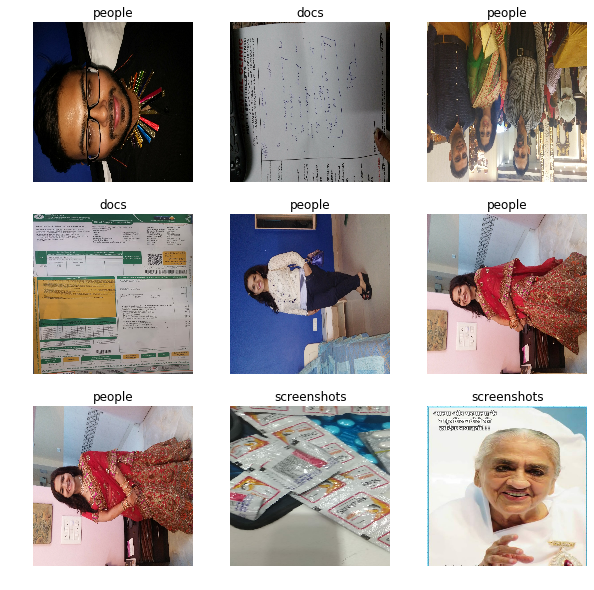

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

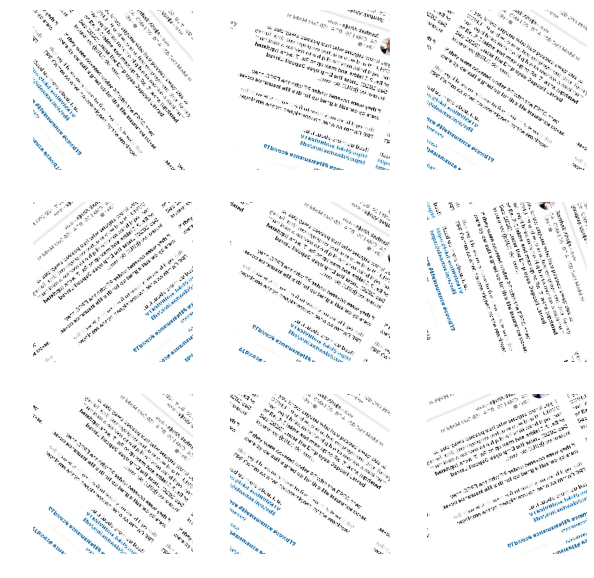

In [6]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [8]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [9]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [10]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [12]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 2, 2, 1, 0, 2, 1, 1, 2, 0, 2, 1, 1, 0, 2, 1, 0, 1, 0, 0, 2,
       1, 2, 1, 1, 2, 1, 2, 1, 2, 1], dtype=int32)>

In [13]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n03598930', 'jigsaw_puzzle', 0.3018671),
  ('n04589890', 'window_screen', 0.07705186)],
 [('n04589890', 'window_screen', 0.6343314),
  ('n03347037', 'fire_screen', 0.050131816)],
 [('n04589890', 'window_screen', 0.17865993),
  ('n03692522', 'loupe', 0.029927142)],
 [('n04589890', 'window_screen', 0.14751415),
  ('n03485794', 'handkerchief', 0.06501957)],
 [('n04589890', 'window_screen', 0.76740944),
  ('n04209239', 'shower_curtain', 0.030955799)],
 [('n04589890', 'window_screen', 0.7143799),
  ('n04404412', 'television', 0.094859764)],
 [('n06359193', 'web_site', 0.23915796),
  ('n04589890', 'window_screen', 0.19464034)],
 [('n04589890', 'window_screen', 0.6645317),
  ('n03887697', 'paper_towel', 0.048627984)],
 [('n04589890', 'window_screen', 0.25334433),
  ('n02879718', 'bow', 0.13178663)],
 [('n06359193', 'web_site', 0.38080803),
  ('n04589890', 'window_screen', 0.20626582)],
 [('n04589890', 'window_screen', 0.54214865),
  ('n03485794', 'handkerchief', 0.16783854)],
 [('n0458989

In [14]:
# UNQ_C2
# GRADED FUNCTION
def ppc_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tfl.Dense(1, 'linear')
    
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [15]:
model2 = ppc_model(IMG_SIZE, data_augmentation)

In [16]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/Users/ankit/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [17]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
22/22 [==============================] - 16s 533ms/step - loss: -2.2088 - accuracy: 0.3483 - val_loss: -4.5845 - val_accuracy: 0.3121
Epoch 2/5
22/22 [==============================] - 13s 508ms/step - loss: -6.7879 - accuracy: 0.3497 - val_loss: -8.7512 - val_accuracy: 0.3121
Epoch 3/5
22/22 [==============================] - 15s 571ms/step - loss: -11.0594 - accuracy: 0.3497 - val_loss: -13.0649 - val_accuracy: 0.3121
Epoch 4/5
22/22 [==============================] - 25s 1s/step - loss: -15.6019 - accuracy: 0.3497 - val_loss: -17.5345 - val_accuracy: 0.3121
Epoch 5/5
22/22 [==============================] - 51s 2s/step - loss: -20.1212 - accuracy: 0.3497 - val_loss: -21.9581 - val_accuracy: 0.3121


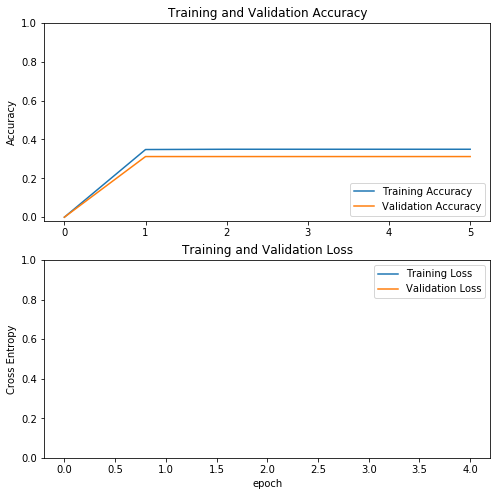

In [18]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
class_names

['docs', 'people', 'screenshots']

In [20]:
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.1 * base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


In [21]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
22/22 [==============================] - 36s 1s/step - loss: -232.5727 - accuracy: 0.3497 - val_loss: -318.4100 - val_accuracy: 0.3121
Epoch 6/10
22/22 [==============================] - 24s 941ms/step - loss: -312.2180 - accuracy: 0.3497 - val_loss: -326.6795 - val_accuracy: 0.3121
Epoch 7/10
22/22 [==============================] - 29s 1s/step - loss: -320.6932 - accuracy: 0.3497 - val_loss: -334.9768 - val_accuracy: 0.3121
Epoch 8/10
22/22 [==============================] - 34s 1s/step - loss: -328.6357 - accuracy: 0.3497 - val_loss: -342.9034 - val_accuracy: 0.3121
Epoch 9/10
22/22 [==============================] - 34s 1s/step - loss: -336.4296 - accuracy: 0.3497 - val_loss: -350.8070 - val_accuracy: 0.3121
Epoch 10/10
22/22 [==============================] - 31s 1s/step - loss: -343.0901 - accuracy: 0.3497 - val_loss: -358.4119 - val_accuracy: 0.3121


In [22]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

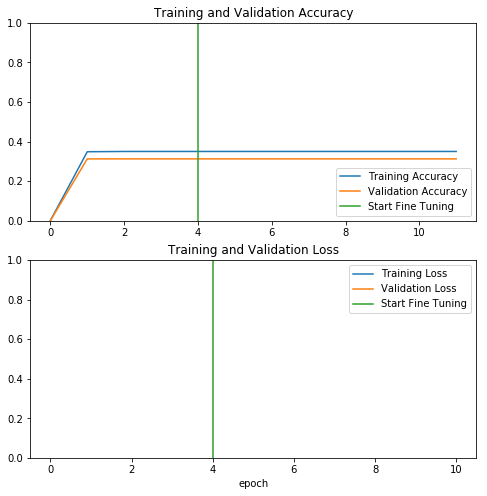

In [23]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()